In [1]:
%run "preamble.ipynb"
%matplotlib inline
import torch
from torch.autograd import Variable
from dl4nlp.util import *
from dl4nlp.einsum import einsum
from torch import nn
import torch.nn.functional as F
import numpy as np
from torch.nn import Parameter
from dl4nlp.tikz import *
from dl4nlp.rnn import *
import IPython.display
IPython.display.display_latex(IPython.display.Latex(filename="tex/macros.tex"))

<IPython.core.display.Javascript object>

<center>
<h1>Deep Learning for Natural Language Processing III</h1>
<h2>Attention</h2>
<br>
Tim Rocktäschel<br>
<a href="https://rockt.github.com">rockt.github.com</a> <a href="mailto:tim.rocktaschel@cs.ox.ac.uk">tim.rocktaschel@cs.ox.ac.uk</a> <a href="https://twitter.com/_rockt">Twitter: @_rockt</a><br>
<img src="./figures/oxford.svg" width=30%><br>
2nd Int'l Summer School on Data Science, Split, Croatia<br>
27th September 2017<br>
</center>

# Why you should know about <span class=orange>einsum</span>
- We often need to carry out computations on higher-order tensors $A$ and $B$ using the following steps
  - **multiply** A with B (e.g. tensor contractions)
  - **sum** resulting tensor along specific axes
  - **transpose** the axes in a specific particular order
- Even worse: we often have to **reshape** to matrices (flatten) and back to tensors
- Need to remember API functions
- <span class=green>einsum</span> to the rescue!

# <span class=orange>einsum</span>
- Assume we want to mutliply two matrices $\mat{A}\in\R^{i\times j}, \mat{B}\in\R^{k\times j}$ and transpose afterwards, resulting in a matrix $\mat{C}\in\R^{k\times i}$
- Can be done with a single call of einsum
## $${\color{nice-green}\mat{C}} = \text{einsum}("{\color{nice-red}ij},{\color{nice-blue}kj}\text{->}{\color{nice-green}ki}", {\color{nice-red}\mat{A}}, {\color{nice-blue}\mat{B}})$$
- Based on Einstein notation
$$
\mat{C}_{ki} := \sum_i \mat{A}_{ij} * \mat{B}_{ki}
$$
- Advanced example with order-3 tensors $\ten{A}\in\R^{a\times i\times j}, \mat{B}\in\R^{a\times j\times c}$
## $${\color{nice-green}\mat{C}} = \text{einsum}("{\color{nice-red}aij},{\color{nice-blue}ajc}\text{->}{\color{nice-green}ic}", {\color{nice-red}\ten{A}}, {\color{nice-blue}\ten{B}})$$
$$
\mat{C}_{ic} := \sum_a\sum_j \ten{A}_{aij} * \ten{B}_{ajc}
$$
- Implemented in numpy and TensorFlow; coming to PyTorch soon


# <span class=orange>einsum</span> Is All You Need

In [2]:
x = torch.randn(5); y = torch.randn(7)
A = torch.randn(3, 5); B = torch.randn(2, 5)
C = torch.randn(2, 3, 5); D = torch.randn(2, 5, 7)
E = torch.randn(7, 9)

# -- Vector
einsum("i->", x)                 # sum
einsum("i,i->", x, x)            # dot
einsum("i,i->i", x, x)           # vector element-wise mul
einsum("i,j->ij", x, y)          # outer
# -- Matrix
einsum("ij->ji", A)              # transpose
einsum("ij->j", A)               # row sum
einsum("ij->i", A)               # col sum
einsum("ij,ij->ij", A, A)        # matrix element-wise mul
einsum("ij,j->i", A, x)          # matrix vector multiplication
einsum("ij,kj->ik", A, B)        # matrix multiplication
einsum("ij,ab->ijab", A, E)      # matrix outer product
# -- Tensor
einsum("aij,ajk->aik", C, D)     # batch matrix multiplication
einsum("ijk,jk->i", C, A)        # tensor matrix contraction
einsum("aij,jk->aik", D, E)      # tensor matrix contraction
einsum("aij,ajc->ic", C, D)      # tensor tensor contraction


-1.2084  1.1496  1.1823 -4.8942 -2.7764 -0.1487  0.4315
-2.9622  0.7737 -2.2043 -1.7621 -0.9894  2.1924 -1.1106
 1.1605 -1.6496 -0.7415  3.3415  2.1216  1.2239  5.5364
[torch.FloatTensor of size 3x7]

# Attention
- Bottleneck in RNNs: everything is squeezed through hidden state
- Idea: learn to attend over previous outputs of an RNN
<img src="./figures/3-attention/attention.svg" width=60%/> 
- Given previous outputs (context) $\mat{Y} = [\vec{y}_1, \vec{y}_2, \ldots, \vec{y}_N]$, hidden representation $\vec{h}^*_t$ is calculated as follows:
\begin{align}
  \mat{M}_t &= \tanh\left(\mat{W}^y\mat{Y}+\left(\mat{W}^h\vec{h}_t\right)\vec{1}^T\right)&\mat{M}_t&\in\R^{k \times N}\label{eq:att-rec}\\
  \vec{\alpha}_t &= \softmax\left(\vec{w}^T\mat{M}_t\right)&\vec{\alpha}_t&\in\R^{1\times N}\\
  \vec{r}_t &= \mat{Y}\vec{\alpha}^T_t &\vec{r}_t&\in\R^k\\
  \vec{h}^*_t &= \tanh(\mat{W}^p\vec{r}_t + \mat{W}^x\vec{h}_t) & \vec{h}^*_t&\in\R^k
\end{align}


<div class=cite> [Graves 2013, Bahdanau et al. 2015, Rocktäschel et al. 2016]</div>

In [3]:
I1 = Variable(torch.from_numpy(np.random.randint(0, vocab_size, [batch_size, seq_length])))
X1 = emb(I1)
s0 = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
Y, S = rnn(gru_cell, X1, s0)
Y = torch.stack(Y, dim=1)

ht = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
rt = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
Wy = nn.init.normal(Parameter(torch.randn(k_out, k_out)))
Wh = nn.init.normal(Parameter(torch.randn(k_out, k_out)))
Wp = nn.Linear(k_out, k_out)
Wx = nn.Linear(k_out, k_out)
w = nn.init.normal(Parameter(torch.randn(k_out)))

def attention(Y, ht, rt):
    # -- [batch_size x seq_length x k_out]
    Y = einsum("ijk,ka->ija", Y, Wy)
    # -- [batch_size x seq_length x k_out]    
    H = ht.unsqueeze(1).expand_as(Y)
    H = einsum("ijk,ka->ija", H, Wh)
    Mt = F.tanh(Y + H)
    # -- [batch_size x seq_length]
    at = F.softmax(einsum("ijk,k->ij", Mt, w))
    # -- [batch_size x k_out]
    rt1 = einsum("ijk,ij->ik", Y, at)
    ht1 = F.tanh(Wp(rt) + Wx(ht))
    return ht1, at, rt1

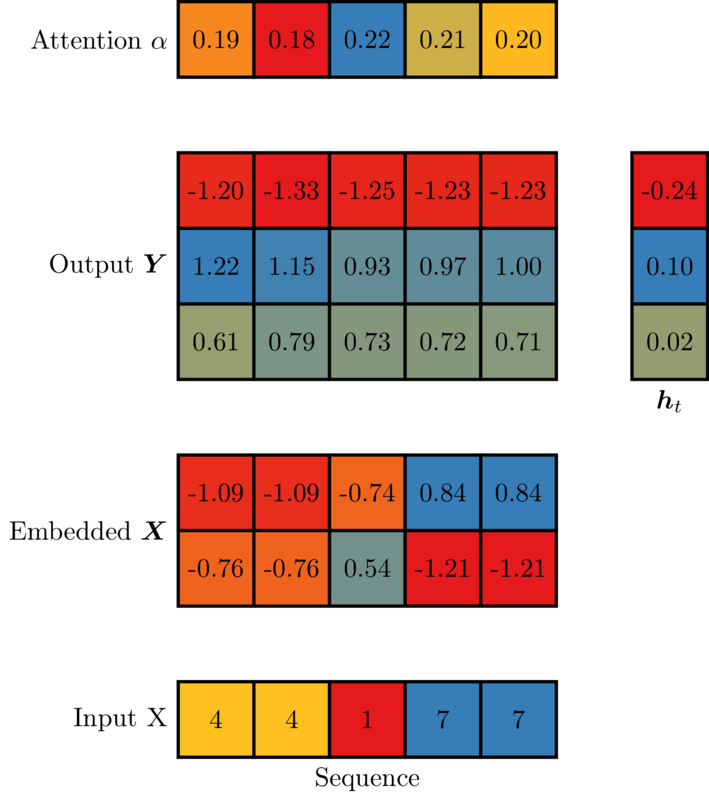

In [4]:
ht1, a, _ = attention(Y, ht, rt)
fig = plot_matrix(I1[0].unsqueeze(0)) + \
  labels(I1[0].unsqueeze(0), r"Sequence", "Input $\ls{X}$")
fig += shift(plot_matrix(X1[0].transpose(1, 0)) + 
             labels(X1[0].transpose(1, 0), 
                    ylabel=r"Embedded $\mat{X}$"), y=2)
fig += shift(plot_matrix(Y[0].transpose(1, 0)) + 
             labels(Y[0].transpose(1, 0), 
                    ylabel=r"Output $\mat{Y}$"), y=3+k_in)
fig += shift(plot_matrix(a[0].unsqueeze(0)) +
             labels(a[0].unsqueeze(0), 
                    ylabel=r"Attention $\alpha$"), y=4+k_in+k_out)
fig += shift(plot_matrix(ht[0].unsqueeze(1)) +
             labels(ht[0].unsqueeze(1), 
                    xlabel=r"$\vec{h}_t$"), 
             x=seq_length+1,
             y=3+k_in)
tikz(fig, height=800)

# Use-case: Recognizing Textual Entailment (RTE)

- **A wedding party is taking pictures**
  - There is a funeral					: **<span class=red>Contradiction</span>**
  - They are outside					: **<span class=blue>Neutral</span>**
  - Someone got married				    : **<span class=green>Entailment</span>**

#### State of the Art until 2015

- Engineered natural language processing pipelines
- Various external resources
- Specialized subcomponents
- Extensive manual creation of **features**:
  - Negation detection, word overlap, part-of-speech tags, dependency parses, alignment, unaligned matching, chunk alignment, synonym, hypernym, antonym, denotation graph
  
<div class=cite>[Lai and Hockenmaier, 2014, Jimenez et al., 2014, Zhao et al., 2014, Beltagy et al., 2015, ...]</div>

### Neural Networks for RTE

**Previous RTE corpora**:
- Tiny data sets (1k-10k examples)
- Partly synthetic examples

<img src="./figures/proprietary/zoidberg.gif">

**Stanford Natural Inference Corpus (SNLI)**:
- 500k sentence pairs
- Two orders of magnitude larger than existing RTE data set
- All examples generated by humans

<img src="./figures/proprietary/gromit.gif">

### Independent Sentence Encoding

Same LSTM encodes premise and hypothesis

<img src="./figures/3-attention/independent.svg" width=60%/> 

<div class=cite>[Bowman et al, 2015]</div>


> You can’t cram the meaning of a whole
%&!\$# sentence into a single \$&!#* vector!
>
> -- <cite>Raymond J. Mooney</cite>

### Independent Sentence Encoding

<img src="./figures/3-attention/mlp.svg" width=60%/> 

<div class=cite>[Bowman et al, 2015]</div>


## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|

### Conditional Endcoding

<img src="figures/3-attention/conditional_encoding.svg" width=60%/> 

\begin{align}
\text{softmax}(\text{tanh}(\mathbf{W}\mathbf{h}_N))
\end{align}

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Endcoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|

### Attention

<img src="./figures/3-attention/attention_encoding.svg" width=60%/> 

<div class=small>
\begin{align}
  \mathbf{M} &= \tanh(\mathbf{W}^y\mathbf{Y}+ \mathbf{W}^h\mathbf{h}_N\mathbf{1}^T_L)&\mathbf{M}&\in\mathbb{R}^{k \times L}\\
  \alpha &= \text{softmax}(\mathbf{w}^T\mathbf{M})&\alpha&\in\mathbb{R}^L\\
  \mathbf{r} &= \mathbf{Y}\alpha^T&\mathbf{r}&\in\mathbb{R}^k
\end{align}
</div>

<div class=cite> [Graves 2013, Bahdanau et al. 2015]</div>

<img  src="./figures/3-attention/camel.png"/>

## Contextual Understanding
<img  src="./figures/3-attention/pink.png"/>

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Encoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|
| Attention | 100 | 3.9M | 242k | 85.4 | 83.2 | 82.3 |

## Fuzzy Attention
<img  src="./figures/3-attention/mimes.png"/>

# Word-by-word Attention

<img src="./figures/3-attention/word_attention_encoding.svg" width=60%/> 

<div class=small>
\begin{align}
  \mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})\mathbf{1}^T_L) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
  \alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
  \mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align}
</div>
<div class=cite>[Bahdanau et al. 2015, Hermann et al. 2015, Rush et al. 2015, Rocktäschel et al. 2016]</div>

## Reordering
<img src="./figures/3-attention/reordering.png" width=40%/>

## Garbage Can = Trashcan
<img  src="./figures/3-attention/trashcan.png" width=70%/>

## Kids =  Girl + Boy
<img  src="./figures/3-attention/kids.png" width=60%/>

## Snow is outside
<img  src="./figures/3-attention/snow.png" width=90%/>

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Encoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|
| Attention | 100 | 3.9M | 242k | 85.4 | 83.2 | 82.3 |
| Word-by-word Attention | 100 | 3.9M | 252k | 85.3 | **83.7** | **83.5** |

# Attention Is All You Need

Model Architecture | Scaled Dot-Product Attention | Multi-Head Attention
:--:|:--:|:--:
<img src="./figures/proprietary/vaswani2017attention/ModalNet-21.png" width=500>  | <img src="./figures/proprietary/vaswani2017attention/ModalNet-19.png" width=300> | <img src="./figures/proprietary/vaswani2017attention/ModalNet-20.png" width=400>

<div class=cite><a href="https://arxiv.org/abs/1706.03762">[Vaswani et al, 2017]</a></div>

# Further Reading
- [Bilaniuk. Einstein Summation in Numpy. 2016.](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/)